In [2]:
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import shapefile as shp
from math import *
from matplotlib.lines import Line2D
import string
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Latex

In [3]:
# Fonction de moyenne par range d'altitude #

# Note : Le fichier orographie doit avoir les même dim spatial que le ds input

def mean_per_alt(data,ls_range,oro_file,wat = 'arome'): # data : dataset, ls_range : array des altitudes, oro_file : PGD
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('x','y')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('x','y')))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    std = xr.concat(std,dim = 'ZS')
    ds['ZS']  = all_ZS
    std['ZS'] = all_ZS
    return std, ds

####################################################################################

def calc_mean(data,mean_type):

    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='1MS').sum(skipna = False)
        else: 
            ds_res = data.resample(time='1MS').mean()
    
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time')
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='Q-FEB').sum(skipna = False)
        else: 
            ds_res = data.resample(time='Q-FEB').mean()
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time')
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean['season'] = ls_name
        
    return ds_mean

def calc_ratio_ar(data):
    ratio = (data.neige+data.graupel)/(data.accpluie+data.neige+data.graupel)
    return ratio

def calc_ratio_s2m(data):
    return (data.Snowf/(data.Rainf+data.Snowf))

def calc_ratio_aladin(data):
    ratio = (data.prsn)/(data.pr+data.prsn)
    return ratio

def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M')[1])
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ar == i), ls_range, oro_ar)[1])

    elif style == 'ALADIN':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ala == i), ls_range, oro_ala)[1])
        
    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif




In [4]:
def agreg_per_alt(data,ls_range,oro_file,wat = 'arome'):
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    ds['ZS']= all_ZS
    return ds

def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(agreg_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M'))
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(agreg_per_alt(data.where(mask_massif_ar == i), ls_range, oro_ar))

    elif style == 'ALADIN':
        
        for i in range(0,23):
            data_alt_massif.append(agreg_per_alt(data.where(mask_massif_ala == i), ls_range, oro_ala))
        
    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif


In [5]:
##################
# INITIALISATION #
##################

data_path_arome = '/home/monteirod/STAGEIENM3/data_AROME/'
data_path_ADAMONT = '/home/monteirod/STAGEIENM3/data_Adamont/'
data_path_ALADIN = '/home/monteirod/STAGEIENM3/data_Aladin/'

all_ZS = np.arange(0,5100,300)
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

massif = geopandas.read_file('/home/monteirod/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
massif_name=np.array(massif.nom) # Nom des massifs dans l'ordre indice
massif_nums2m = np.array(massif.massif_num) # Numero des massifs dans l'ordre de l'article Arome/Safran
sf = shp.Reader('/home/monteirod/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

##########################
# Load mask & topo arome #
##########################

name_oro = 'PGD_setgrid_subset.nc'
oro_ar = xr.open_dataset(data_path_arome+'PGD/'+name_oro)

mask_massif_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_massif_subset.nc')
mask_massif_ar = mask_massif_ar['__xarray_dataarray_variable__']
mask_massif_ar = mask_massif_ar.rename({'X':'x','Y':'y'})

mask_all_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_all_subset.nc')
mask_all_ar = mask_all_ar['SFX.AVG_ZS']
mask_all_ar = mask_all_ar.rename({'X':'x','Y':'y'})

oro_ar = oro_ar['SFX.AVG_ZS']
lon_ar = oro_ar.lon[0,:].values
lat_ar = oro_ar.lat[:,0].values
oro_ar = oro_ar.rename({'X':'x','Y':'y'})
oro_ar['y'] = lat_ar
oro_ar['x'] = lon_ar


file_extra = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/file_extra.nc')

#################
# Load DS arome #
#################

all_var = ['Air temperature at 2m','Total precipitation','Fraction of solid precipitation','Snow depth']
all_unit = [' (°C)',' (kg m$^{-2}$)','',' (m)',]

unit = all_unit[0]
var_name = all_var[0]

# run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

# Load monmean #

def load_arome_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat_ar
    ar_monmean['x'] = lon_ar
    return ar_monmean

###########################
# Load mask & topo ALADIN #
###########################


oro_ala_MED = xr.open_dataset(data_path_ALADIN+'orog_MED-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_massif_subset.nc')
mask_all_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_all_subset.nc')

mask_massif_ala_MED = mask_massif_ala_MED['__xarray_dataarray_variable__']
mask_all_ala_MED = mask_all_ala_MED.orog

oro_ala_MED = oro_ala_MED.orog
lon_MED = oro_ala_MED.lat[:,0].values
lat_MED = oro_ala_MED.lon[0,:].values
oro_ala_MED['x'] = lat_MED
oro_ala_MED['y'] = lon_MED

oro_ala_EUR = xr.open_dataset(data_path_ALADIN+'orog_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_massif_subset.nc')
mask_all_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_all_subset.nc')

mask_massif_ala_EUR = mask_massif_ala_EUR['__xarray_dataarray_variable__']
mask_all_ala_EUR = mask_all_ala_EUR.orog

oro_ala_EUR = oro_ala_EUR.orog
lon_EUR = oro_ala_EUR.lat[:,0].values
lat_EUR = oro_ala_EUR.lon[0,:].values
oro_ala_EUR['x'] = lat_EUR
oro_ala_EUR['y'] = lon_EUR

def load_aladin_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/t2m/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = (ar_monmean.pr + ar_monmean.prsn)*3600*24
    if var_name == all_var[2]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        if run == 'HISTORICAL':
            ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600*24
        if run == 'run_eval':
            ar_monmean = ar_monmean.drop_vars(('nav_lon_bnds', 'nav_lat_bnds', 'time_counter_bnds'))*3600*24
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/snd/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    if run == 'run_eval':
        ar_monmean['x'] = lat_MED
        ar_monmean['y'] = lon_MED
        ar_monmean = ar_monmean.rename({'time_counter': 'time'})
    else:
        ar_monmean['x'] = lat_EUR
        ar_monmean['y'] = lon_EUR
        
    return ar_monmean


#####################
# Load DS ADAMONT   #
#####################

# Hiver 1996/1997 se situe en 1997

def load_Adam_ds(var_name):
        
    if var_name == all_var[0]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/pro_adamont_'+run+'.nc')
        data = data.DSN_T_ISBA
        
    return data

#################
# Load DS S2M   #
#################

def load_ds_s2m(var_name):
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Tair_1958_2018.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/snow_1958_2018.nc')
        data = data.DSN_T_ISBA

    return data


NameError: name 'oro_per_massif' is not defined

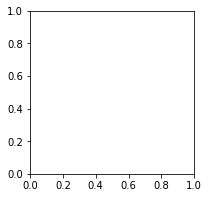

In [5]:
# Plot la figure avec les contours des massifs, ceux contenant les niveaux d'altitudes sont grisées,
# ceux qui ne les contiennent pas sont blancs

plt.figure(figsize=(10,3))
plot_number = 1

plot_ZS_range = np.arange(900,3600,900)
letter = ['a) ', 'b) ', 'c) ']
for i in range(0,len(plot_ZS_range)):
    
    ax = plt.subplot(1, 3, plot_number)
    alt_i = plot_ZS_range[i]
    
    contour = oro_per_massif.where(mask_all == True).sel(massif = mass.sel(ZS = alt_i ).dropna('massif').massif.values).sum(dim = 'massif')
    contour = contour.where(contour == 0, 1)

    colors = ['white','darkgrey']
    cmap= m.colors.ListedColormap(colors)
    plt.contourf(contour.lon, contour.lat, contour ,cmap = cmap)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    def plot_map(sf, x_lim = None, y_lim = None):
        for shape in sf.shapeRecords():
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            ax.plot(x, y, 'black', linewidth = 0.7)
    plot_map(sf)
    
    plt.title(letter[i]+"Intersecting massifs at "+str(alt_i)+'m')
    plot_number = plot_number + 1
    
plt.tight_layout()
# plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/nb_massif_per_alt.png')

In [68]:
###########################
# DEFINE VARIABLE & TREAT #
###########################

# Aggregate them per alt & per massif #

run = 'HISTORICAL'
yr_1 = 1996
yr_2 = 2005

ar_all, s2m_all = load_arome_mean_ds(var_name).sel(time = slice(str(yr_1),str(yr_2))), load_ds_s2m(var_name).sel(time = slice(str(yr_1),str(yr_2)))
ala_all_EUR = load_aladin_mean_ds(var_name).sel(time = slice(str(yr_1),str(yr_2)))
##########################################################

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR , oro_ala_EUR
ar_alt_massif, s2m_alt_massif = per_alt_per_massif(ar_all, 'arome'), per_alt_per_massif(s2m_all, 'S2M')
ala_alt_massif_EUR =  per_alt_per_massif(ala_all_EUR, 'ALADIN')

run = 'run_eval'
yr_1 = 1990
yr_2 = 2000
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED
ala_all_MED = load_aladin_mean_ds(var_name).sel(time = slice(str(yr_1),str(yr_2)))
ala_alt_massif_MED =  per_alt_per_massif(ala_all_MED, 'ALADIN')


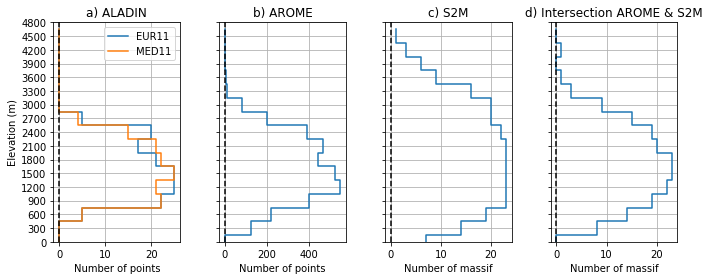

In [95]:
################
### Calc pts ###
################

# Calcule puis plot en profil V. le nombre de point présent par niveau d'altitude (+-150m), $
# pour chacun des jeux de données ALADIN/AROME/S2M et l'intersection AROME/S2M

def count_point(data,ls_range, oro_file, wat = 'arome'):
    nb_points = []
    for i in range(0,len(ls_range)-1):
        if wat == 'arome':

            if len(data.dims) == 2:
                nb_points.append(np.sum(np.count_nonzero(~np.isnan(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]))), 0)))
            else:
                nb_points.append(np.sum(np.count_nonzero(~np.isnan(data[0,:,:].where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]))), 0)))

        if wat == 'aladin':

            if len(data.dims) == 2:
                nb_points.append(np.sum(np.count_nonzero(~np.isnan(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]))), 0)))
            else:
                nb_points.append(np.sum(np.count_nonzero(~np.isnan(data[0,:,:].where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]))), 0)))

        elif wat == 'S2M':
            nb_points.append(np.count_nonzero(~np.isnan(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]))), 1)[0])

    return nb_points
                
# Calculate nb points per altitude #


nb_point_arome = []
nb_point_s2m = []
nb_point_aladin_EUR = []
nb_point_aladin_MED = []

for i in range(0,23):

    nb_point_arome.append(count_point(ar_all.isel(time = 0).where(mask_massif_ar == i), ls_range, oro_ar))
    nb_point_s2m.append(count_point(s2m_all.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M'))
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR , oro_ala_EUR
    nb_point_aladin_EUR.append(count_point(ala_all_EUR.isel(time = 0).where(mask_massif_ala == i), ls_range, oro_ala))
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED
    nb_point_aladin_MED.append(count_point(ala_all_MED.isel(time = 0).where(mask_massif_ala == i), ls_range, oro_ala))

nb_point_arome_per_alt = []
nb_point_aladin_per_alt_EUR = []
nb_point_aladin_per_alt_MED = []

for i in range(0,17):
    a = 0
    b = 0
    c = 0
    for j in range(0,23):
        a = a + (nb_point_arome[j][i])
        b = b + (nb_point_aladin_EUR[j][i])
        c = c + (nb_point_aladin_MED[j][i])

    nb_point_arome_per_alt.append(a)
    nb_point_aladin_per_alt_EUR.append(b)
    nb_point_aladin_per_alt_MED.append(c)

nb_point_arome_per_alt = xr.DataArray(nb_point_arome_per_alt, coords = [all_ZS], dims = 'ZS')
nb_point_aladin_per_alt_EUR = xr.DataArray(nb_point_aladin_per_alt_EUR, coords = [all_ZS], dims = 'ZS')
nb_point_aladin_per_alt_MED = xr.DataArray(nb_point_aladin_per_alt_MED, coords = [all_ZS], dims = 'ZS')


########################################################################

#Points ALADIN EUR11 per alt #

fig = plt.figure(figsize=(10,4))

plot_number = 1
ax = plt.subplot(1, 4, plot_number)

ax.step(nb_point_aladin_per_alt_EUR, nb_point_aladin_per_alt_EUR.ZS-150, where='pre', label = 'EUR11')
ax.step(nb_point_aladin_per_alt_MED, nb_point_aladin_per_alt_MED.ZS-150, where='pre', label = 'MED11')
ax.plot([0]*len(nb_point_aladin_per_alt.ZS), nb_point_aladin_per_alt.ZS, linestyle = '--', color = 'k')
ax.legend()
ax.set_yticks(nb_point_aladin_per_alt.ZS)
ax.set_xlabel('Number of points')
ax.set_ylabel('Elevation (m)')
ax.set_title('a) ALADIN')
ax.set_ylim(0,4800)
#plt.xscale('log')
ax.grid()


plot_number = 2
ax = plt.subplot(1, 4, plot_number)

ax.step(nb_point_arome_per_alt, nb_point_arome_per_alt.ZS-150, where='pre')
ax.plot([0]*len(nb_point_arome_per_alt.ZS), nb_point_arome_per_alt.ZS, linestyle = '--', color = 'k')
ax.set_yticks(nb_point_arome_per_alt.ZS)
ax.set_xlabel('Number of points')
# ax.set_ylabel('Elevation (m)')
ax.set_title('b) AROME')
ax.set_ylim(0,4800)
ax.grid()
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

# Nb massif arome per alt #

plot_number = 3
ax = plt.subplot(1, 4, plot_number)

nb_massif_per_alt = []
for i in all_ZS:
    nb_massif_per_alt.append(len(ar_alt_massif.isel(time = 0).sel(ZS = i).dropna(dim = 'massif')))

nb_massif_per_s2m = []
for i in range(0,17):
    a = 0
    for j in range(0,23):
        a = a + (nb_point_s2m[j][i])
    nb_massif_per_s2m.append(a)
nb_massif_per_s2m = xr.DataArray(nb_massif_per_s2m, coords = [all_ZS], dims = 'ZS')

ax.step(nb_massif_per_s2m, nb_massif_per_s2m.ZS-150, where='pre')
ax.plot([0]*len(nb_massif_per_s2m.ZS), nb_massif_per_s2m.ZS, linestyle = '--', color = 'k')
ax.set_xlabel('Number of massif')
ax.set_yticks(nb_massif_per_s2m.ZS.ZS)
# ax.set_ylabel('Elevation (m)')
ax.set_title('c) S2M')
ax.set_ylim(0,4800)
ax.grid()
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

# Nb massif arome per alt #

plot_number = 4
ax = plt.subplot(1, 4, plot_number)

ax.step(nb_massif_per_alt, ar_alt_massif.ZS-150, where='pre')
ax.plot([0]*len(ar_alt_massif.ZS), ar_alt_massif.ZS, linestyle = '--', color = 'k')
ax.set_xlabel('Number of massif')
# ax.set_ylabel('Elevation (m)')
ax.set_title('d) Intersection AROME & S2M')
ax.set_yticks(ar_alt_massif.ZS.ZS)
ax.set_ylim(0,4800)
ax.grid()
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

plt.tight_layout()

plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/adaptation_nb_points_all.png')

# Nbre de massif par niveau d'altitude pour ALADIN brute #

nb_massif_per_alt_EUR = []
for i in all_ZS:
    nb_massif_per_alt_EUR.append(len(ala_alt_massif_EUR.isel(time = 0).sel(ZS = i).dropna(dim = 'massif')))

nb_massif_per_alt_MED = []
for i in all_ZS:
    nb_massif_per_alt_MED.append(len(ala_alt_massif_MED.isel(time = 0).sel(ZS = i).dropna(dim = 'massif')))

nb_massif_per_alt_EUR, nb_massif_per_alt_MED

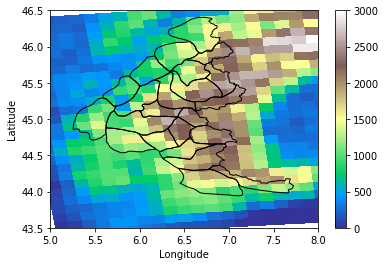

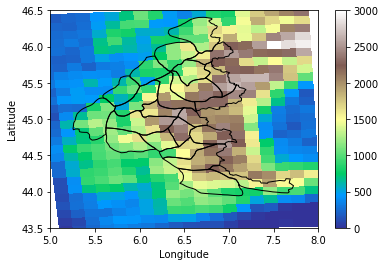

In [9]:
### Plot l'orographie de ALADIN-MED11 et EUR11 ###

sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

oro_ala, mask_all_ala = oro_ala_MED, mask_all_ala_MED

plt.pcolor(oro_ala.lon,oro_ala.lat,oro_ala, cmap = 'terrain', vmin = 0, vmax = 3000)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(5,8)
plt.ylim(43.5,46.5)
plt.colorbar()
def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1)
plot_map(sf)

plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Orog_ALADIN_MED11_nonmasked.png')

### MASK ORO ALA EUR11 ###
oro_ala, mask_all_ala = oro_ala_EUR, mask_all_ala_EUR

plt.figure()
plt.pcolor(oro_ala.lon,oro_ala.lat,oro_ala, cmap = 'terrain', vmin = 0, vmax = 3000)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(5,8)
plt.ylim(43.5,46.5)
plt.colorbar()
sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1)
plot_map(sf)
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Orog_ALADIN_EUR11_nonmasked.png')


In [ ]:
# Diapo pour oral stage #

# Premiere image #

# run = 'run_eval'
# Temp = load_arome_mean_ds(all_var[0]).mean(dim = 'time')
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

data = oro_ar

sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

massif = geopandas.read_file('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
mask_mas = regionmask.Regions_cls(name = 'massif_mask', numbers = list(range(0,23)), names = list(massif.nom), abbrevs = list(massif.nom_reduit), outlines = list(massif.geometry.values[i] for i in range(0,23)))
mask_massif = mask_mas.mask(oro_ar, lat_name='lat', lon_name='lon')


a = oro_ar.where((mask_massif != 0) & (mask_massif != 1) & (mask_massif != 2) &  
                      (mask_massif != 4) & (mask_massif != 5) & (mask_massif != 6) ,True)
mask_ar_restr = a.where(a == True)


###################################""

plt.figure(figsize = (8,8))

plt.pcolor(data.lon,data.lat,data,vmin = 0,vmax = 4800, cmap = 'terrain')
plt.colorbar()
plt.ylim(45.24,46.5)
plt.xlim(6.16,7.1)

def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1.8)
plot_map(sf)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Agreg_AROME_1.png')

# Deuxieme image #

plt.figure(figsize = (8,8))

def agreg_per_alt(data,ls_range,oro_file):
    ds = []
    
    for i in range(0,len(ls_range)-1):
        ds.append(data.where(~(oro_file<ls_range[i+1])*(oro_file>=ls_range[i]),ls_range[i]+150).where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i]),0))

    ds = xr.concat(ds,dim='ZS')
    ds['ZS']= all_ZS
    return ds

oro_agreg = agreg_per_alt(data,ls_range,oro_ar)
oro_agreg_sum = oro_agreg.sum(dim = 'ZS')

plt.pcolor(oro_agreg.lon, oro_agreg.lat,oro_agreg_sum,vmin = 0,vmax = 4800, cmap = 'terrain')
plt.colorbar()
plt.ylim(45.24,46.5)
plt.xlim(6.16,7.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1.8)
plot_map(sf)
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Agreg_AROME_2.png')

# Troisieme image #

plt.figure(figsize = (8,8))
plt.pcolor(oro_agreg.lon, oro_agreg.lat,oro_agreg_sum.where(mask_ar_restr == True),vmin = 0,vmax = 4800, cmap = 'terrain')
plt.colorbar()
plt.ylim(45.24,46.5)
plt.xlim(6.16,7.1)

def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1.8)
plot_map(sf)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Agreg_AROME_3.png')

# Quatrieme image #

plt.figure(figsize = (8,8))
plt.pcolor(oro_agreg.lon, oro_agreg.lat,oro_agreg.sel(ZS = 1800).where(oro_agreg.sel(ZS =1800)==1800, np.nan).where(mask_ar_restr == True),vmin = 0,vmax = 4800, cmap = 'terrain')
plt.colorbar()
plt.ylim(45.24,46.5)
plt.xlim(6.16,7.1)

def plot_map(sf, x_lim = None, y_lim = None):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k', linewidth = 1.8)
plot_map(sf)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Agreg_AROME_4.png')

### Courbe Hypsométrique ###


data = oro_ar.where(mask_all_ar==True)
#ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4200]
ls_range = np.arange(0,4210,10)

ds = []
ls_range_name = []

for i in range(0,len(ls_range)-1):
    
    ds.append(data.where((data<ls_range[i+1])*(data>=ls_range[i])).count())
    
    ls_range_name.append(str(ls_range[i])+'-'+str(ls_range[i+1]))
    
ds = xr.concat(ds,dim='ZS_range')
ds['ZS_range']  = ls_range_name
ds_tot = sum(ds)

for i in range(1,len(ds)):
    ds_1 = ds[i-1]
    ds[i] = ds[i] + ds_1
ds_non_agreg = (ds/ds_tot)*100

################################

data = oro_agreg_sum.where(mask_all_ar==True)
ds = []
ls_range_name = []

for i in range(0,len(ls_range)-1):
    
    ds.append(data.where((data<ls_range[i+1])*(data>=ls_range[i])).count())
    
    ls_range_name.append(str(ls_range[i])+'-'+str(ls_range[i+1]))
    
ds = xr.concat(ds,dim='ZS_range')
ds['ZS_range']  = ls_range_name
ds_tot = sum(ds)

for i in range(1,len(ds)):
    ds_1 = ds[i-1]
    ds[i] = ds[i] + ds_1
ds_agreg = (ds/ds_tot)*100

plt.figure(figsize=(8,8))
plt.plot(ds_non_agreg.values,ls_range[0:-1],label = 'Données brutes')
plt.plot(ds_agreg.values,ls_range[0:-1],label = 'Données agrégées')
plt.legend()
plt.yticks(np.arange(0,4400,200))
plt.xlabel('Pourcentage cumulé du nombre de points')
plt.ylabel('Altitude (m)')
plt.title('Courbes hypsométriques Alpes françaises')

plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/article/Agreg_AROME_5.png')


In [10]:
# NOTE #

#data = data.groupby('time.year').mean('time') # Pour créer une dimension year


# mask = (oro<4200)*(oro>=3500) # créer un mask true false la ou la condition est respecté, ne s'applique qu'au np.Array
# si tu l'applique a une array il te renvoie directement toutes les valeurs a la suite qui respecte le mask
# np.array(data)[:,mask]

# ind = np.argwhere((np.array(oro)<4200)) # recupere les indices ou la condition est respecté, ne fonctionne qu'avec np.array

# idy,idx = np.where((oro >= 3500) & (oro < 4200)) # marche pas vraiment car pas forcement un tableau a la fin

# test.where((oro >= 4000) & (oro < 4200)) met des nan la ou la condition n'est pas rempli

# ind = np.array(list(zip(idy,idx))) # met idx et idy dans une array [[idx1,idy1],...,[idxn,idyn]]

# test[:,idy][:,:,idx] # selectionne d'abord les y a tout les temps puis les x au y et temps restant

#test.stack(z=('y','x')) # combine les deux dimensions => reshape mais trop long

###############################################################################

# Create massif mask toute confondu # Pour l'appliquer il faut where ... == True

# massif = geopandas.read_file('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
# mask_mas = regionmask.Regions_cls(name = 'massif_mask', numbers = list(range(0,23)), names = list(massif.nom), abbrevs = list(massif.nom_reduit), outlines = list(massif.geometry.values[i] for i in range(0,23)))
# mask_massif = mask_mas.mask(oro, lat_name='lat', lon_name='lon')

# mask_massif.to_netcdf(data_path+'mask_alpes/'+'mask_massif_subset.nc')

# a = oro.where((mask_massif != 0) & (mask_massif != 1) & (mask_massif != 2) & (mask_massif != 3)& 
#                       (mask_massif != 4) & (mask_massif != 5) & (mask_massif != 6) & (mask_massif != 7) &
#                       (mask_massif != 8) & (mask_massif != 9) & (mask_massif != 10) & (mask_massif != 11) &
#                       (mask_massif != 12) & (mask_massif != 13) & (mask_massif != 14) & (mask_massif != 15) &
#                       (mask_massif != 16) & (mask_massif != 17) & (mask_massif !=18) & (mask_massif != 19) &
#                       (mask_massif != 20) & (mask_massif != 21) & (mask_massif != 22),True)
# mask_all = a.where(a == True)

# mask_all.to_netcdf(data_path+'mask_alpes/'+'mask_all_subset.nc')


####################################################################################

# Bad functions to calculate monmean, problem is that it calculate over all years and not years by years


# ds_mean = []

# if mean_type == 'month':

#     num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
#     ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

#     for i in num_index:
#         ds_month = data.sel(time = data.time.dt.month.isin(i)).mean(dim='time')
#         ds_mean.append(ds_month)

#     ds_mean = xr.concat(ds_mean,dim='month')
#     ds_mean['month'] = ls_name

# if mean_type == 'season':

#     ls_name = ['SON','DJF','MAM','JJA']

#     for i in ls_name:
#         ds_season = data.sel(time = data.time.dt.season.isin(i)).mean(dim='time')
#         ds_mean.append(ds_season)

#     ds_mean = xr.concat(ds_mean,dim='season')
#     ds_mean['season'] = ls_name

# return ds_mean